# Dat550 Project

In [1]:
import json
import string
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from textstat import textstat
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse
import seaborn as sns
import matplotlib.pyplot as plt

tqdm.pandas()

## Load Data 

In [ ]:
def load_json(filepath):
    articles = []
    table = str.maketrans("","",string.punctuation+"“”‘’")
    
    with open(filepath, "r", encoding="utf-8") as f:
        total_lines = sum(1 for _ in f)
    
    with open(filepath, "r", encoding="utf-8") as f:
        for line in tqdm(f, total=total_lines, desc="Loading articles"):
            data = json.loads(line)
            title = data["title"].translate(table)
            content = data["content"].translate(table)
            articles.append({
                "id": int(data["id"]),
                "content": f"{title} {content}"
            })
    
    return pd.DataFrame(articles)



def load_ground_truth(filepath):
    return pd.read_json(filepath, orient="records", lines=True)

def merge_with_ground_truth(articles_df, ground_truth_df):
    return articles_df.merge(ground_truth_df[['id', 'hyperpartisan']], on='id', how='left')
        

### Wrapper fucntion for loading data

In [5]:
def prepare_data(article_path, truth_path):
    print("Loading and merging data...")
    articles_df = load_json(article_path)
    ground_truth_df = load_ground_truth(truth_path)
    df = merge_with_ground_truth(articles_df, ground_truth_df)

    # Filter out samples with missing labels
    df = df.dropna(subset=['hyperpartisan'])
    df['label'] = df['hyperpartisan'].astype(int)
    return df

## Feature extraioction
This module is designed to extraction of stylometric, linguistic, and sentiment-based features from the articles. These features are useed for downstream together with the vectorized text

In [6]:
def extract_features(text):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    import textstat
    from collections import Counter
    import re

    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    words = text.lower().split()
    word_counts = Counter(words)
    
    # Emotional/intense language features
    intense_adj = {'absolute', 'utter', 'total', 'complete', 'extreme', 'radical'}
    modal_verbs = {'must', 'should', 'ought', 'shall', 'would'}
    generalization = {'always', 'never', 'every', 'all', 'none', 'no one'}
    
    features = {
        # Sentiment features
        'sent_neg': sentiment['neg'],
        'sent_pos': sentiment['pos'],
        'sent_compound': sentiment['compound'],
        'sent_neu': sentiment['neu'],
        
        # Readability/complexity
        'flesch': textstat.flesch_reading_ease(text),
        'smog': textstat.smog_index(text),
        'lex_div': len(set(words))/len(words) if words else 0,  # type-token ratio
        
        # Punctuation
        'exclam': text.count('!'),
        'questions': text.count('?'),
        'quotes': text.count('"'),
        'all_caps': len(re.findall(r'\b[A-Z]{2,}\b', text)),
        
        # Length
        'length': len(words),
        'avg_word_len': sum(len(w) for w in words)/len(words) if words else 0,
        
        # Content features
        'intense_adj': sum(word_counts.get(adj, 0) for adj in intense_adj),
        'modal_verbs': sum(word_counts.get(mv, 0) for mv in modal_verbs),
        'generalization': sum(word_counts.get(gen, 0) for gen in generalization),
        'num_proper_nouns': len(re.findall(r'\b[A-Z][a-z]+\b', text)),
    }

    return features

def extract_stylometric_features_parallel(df, n_jobs=8):
    texts = df['content'].tolist()
    results = Parallel(n_jobs=n_jobs)(
        delayed(extract_features)(text) for text in tqdm(texts, desc="Extracting Features")
    )
    return pd.DataFrame(results)

## TF-IDF Vectorization for Hyper-Partisan News Detection

This module defines functions for converting raw text into numerical representations using **TF-IDF (Term Frequency-Inverse Document Frequency)**, a commonly used technique in text classification, this time for **hyper-partisan news detection**.

---

**Why Batching?**
- The vocabulary is built incrementally in batches to avoid memory overload and to ensure the vectorizer is exposed to all terms in the dataset.





In [ ]:
def create_text_vectorizer(texts, max_tokens=1000):

    print("Creating TfidfVectorizer...")
    vectorizer = TfidfVectorizer(
        max_features=max_tokens,
        ngram_range=(1, 2),  # Uni-grams + bi-grams
        stop_words='english', 
        sublinear_tf=True     
    )
    
    batch_size = 1000
    for i in tqdm(range(0, len(texts), batch_size), 
                 desc="Building Vocabulary",
                 unit="batch"):
        batch = texts.iloc[i:i+batch_size] if hasattr(texts, 'iloc') else texts[i:i+batch_size]
        vectorizer.fit(batch)  # fit() accumulates vocabulary
    
    return vectorizer

def vectorize_text_in_batches(texts, vectorizer, batch_size=10000):

    all_vectors = []
    
    for i in tqdm(range(0, len(texts), batch_size),
                 desc="Vectorizing Text",
                 unit="batch"):
        batch = texts.iloc[i:i+batch_size] if hasattr(texts, 'iloc') else texts[i:i+batch_size]
        all_vectors.append(vectorizer.transform(batch))  # Returns sparse matrix
    
    return scipy.sparse.vstack(all_vectors)  # Concatenate vertically

## Model training
Helper fucntion to train and evaluate the different models

In [8]:
def train_sklearn_model(model, X_train, X_test, y_train, y_test):
    print(f"\nTraining {model.__class__.__name__}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\nClassification Report ({model.__class__.__name__}):")
    print(classification_report(y_test, preds))

     # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, 
                yticklabels=model.classes_)
    plt.title(f'Confusion Matrix ({model.__class__.__name__})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return model



## Print missclassified
prints out missclassified articles

In [ ]:
def print_misclassified(model, X_test, y_test):

    # Get predictions
    y_pred = model.predict(X_test)
    
    # Identify misclassified samples
    misclassified_mask = (y_test != y_pred)
    n_misclassified = sum(misclassified_mask)
    
    print(f"\nMisclassification Report for {model.__class__.__name__}:")
    print(f"Total misclassified: {n_misclassified}/{len(y_test)} ({n_misclassified/len(y_test):.1%})")

## Load articles

In [10]:
# Load and process articles
df = prepare_data(
    "preprocessing/data/articles-training-byarticle.jsonl",
    "preprocessing/data/ground-truth-training-byarticle.jsonl"
)



Loading and merging data...


Loading articles:   0%|          | 0/645 [00:00<?, ?it/s]

## Vectorize text

In [11]:
vecotorizer = create_text_vectorizer(df["content"])




Creating TfidfVectorizer...


Building Vocabulary:   0%|          | 0/1 [00:00<?, ?batch/s]

In [12]:
X_train = vectorize_text_in_batches(df["content"],vecotorizer)

Vectorizing Text:   0%|          | 0/1 [00:00<?, ?batch/s]

## combine with stylometric features

In [13]:
X_train_combined = scipy.sparse.hstack([
    X_train,
    extract_stylometric_features_parallel(df).values
])

Extracting Features:   0%|          | 0/645 [00:00<?, ?it/s]

## Repeated for test data

In [14]:
test_articles_path = "preprocessing/data/articles-test-byarticle.jsonl"
test_ground_truth_path = "preprocessing/data/ground-truth-test-byarticle.jsonl"

# Load the test data and ground truth as DataFrames
test_articles = pd.read_json(test_articles_path, orient="records", lines=True)
test_ground_truth = pd.read_json(test_ground_truth_path, orient="records", lines=True)

test_articles = test_articles.drop(columns=['hyperpartisan'])
# Merge the two DataFrames
test_data_df = pd.merge(test_articles, test_ground_truth[['id', 'hyperpartisan']], on='id')

X_test = vectorize_text_in_batches(test_data_df["content"], vecotorizer)

X_test_combined = scipy.sparse.hstack([
    X_test,
    extract_stylometric_features_parallel(test_data_df).values
])



Vectorizing Text:   0%|          | 0/1 [00:00<?, ?batch/s]

Extracting Features:   0%|          | 0/628 [00:00<?, ?it/s]

In [ ]:
y_train = df["label"]
y_test = test_data_df["hyperpartisan"].astype(int)




## Logistic Regression


Training LogisticRegression...

Classification Report (LogisticRegression):
              precision    recall  f1-score   support

           0       0.57      0.96      0.72       314
           1       0.88      0.28      0.43       314

    accuracy                           0.62       628
   macro avg       0.73      0.62      0.57       628
weighted avg       0.73      0.62      0.57       628



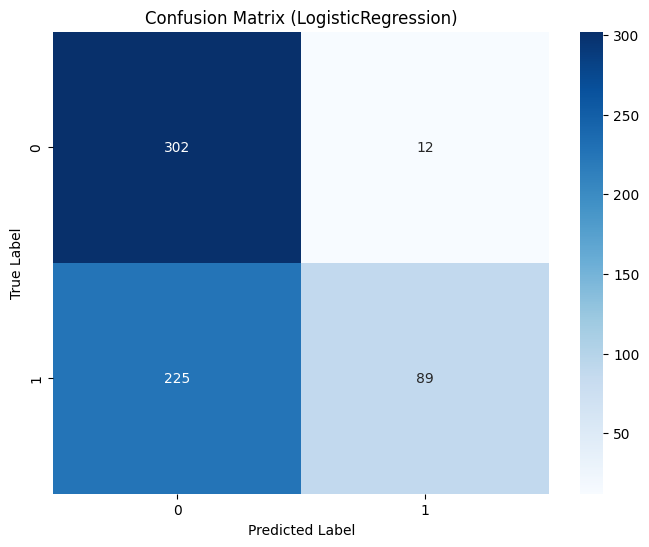


Misclassification Report for LogisticRegression:
Total misclassified: 237/628 (37.7%)


In [16]:
# Train & evaluate
lr_model = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear'
    )

trained_lr = train_sklearn_model(lr_model,X_train_combined,X_test_combined,y_train,y_test)
print_misclassified(trained_lr,X_test_combined,y_test)





## Decision Tree


Training DecisionTreeClassifier...

Classification Report (DecisionTreeClassifier):
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       314
           1       0.70      0.58      0.63       314

    accuracy                           0.66       628
   macro avg       0.67      0.66      0.66       628
weighted avg       0.67      0.66      0.66       628



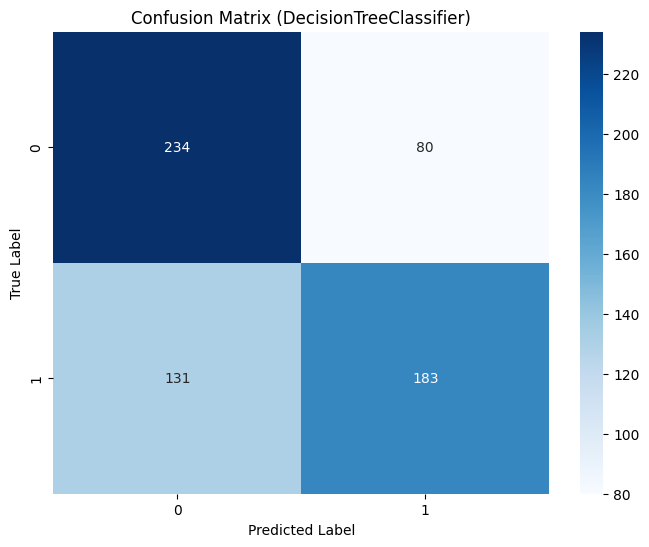


Misclassification Report for DecisionTreeClassifier:
Total misclassified: 211/628 (33.6%)


In [51]:
# Decision Tree
dt_model = DecisionTreeClassifier(criterion="entropy",class_weight='balanced', max_depth=16, random_state=42)
trained_dt = train_sklearn_model(dt_model,X_train_combined,X_test_combined,y_train,y_test)
print_misclassified(trained_dt,X_test_combined,y_test)

### Decsion tree optimization

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
dt = DecisionTreeClassifier(random_state=42)

param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 20),  
    'min_samples_split': randint(2, 10),  
    'min_samples_leaf': randint(1, 5),  
    'max_features': ['sqrt', 'log2', None] 
}

random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=50,  
    cv=5,  
    scoring='recall', 
    random_state=42,  
    n_jobs=-1  
)

random_search.fit(X_train_combined, y_train)

print("Best Parameters (Randomized):", random_search.best_params_)

best_dt_random = random_search.best_estimator_

y_pred = best_dt_random.predict(X_test_combined)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))



Best Parameters (Randomized): {'criterion': 'entropy', 'max_depth': 16, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 8}

Test Set Performance:
              precision    recall  f1-score   support

           0       0.63      0.78      0.70       314
           1       0.71      0.53      0.61       314

    accuracy                           0.66       628
   macro avg       0.67      0.66      0.65       628
weighted avg       0.67      0.66      0.65       628



## Random Forest 


Training RandomForestClassifier...

Classification Report (RandomForestClassifier):
              precision    recall  f1-score   support

           0       0.66      0.89      0.76       314
           1       0.83      0.53      0.65       314

    accuracy                           0.71       628
   macro avg       0.74      0.71      0.70       628
weighted avg       0.74      0.71      0.70       628



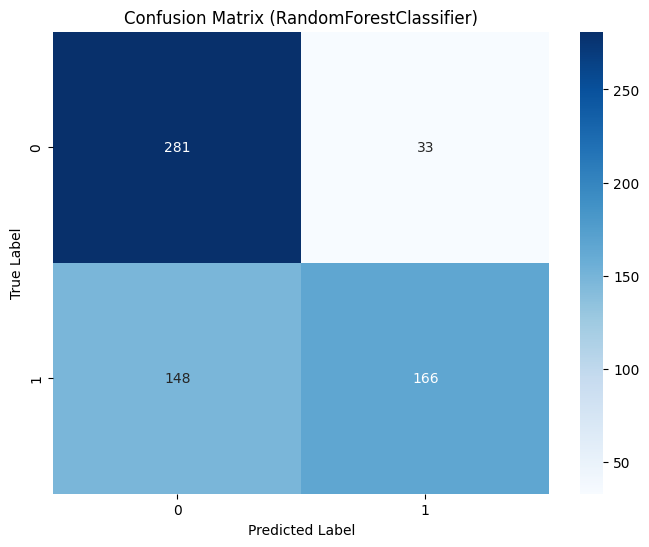


Misclassification Report for RandomForestClassifier:
Total misclassified: 181/628 (28.8%)


In [50]:
# Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=72, max_depth=16, random_state=42)
trained_rf = train_sklearn_model(rf_model,X_train_combined,X_test_combined,y_train,y_test)

print_misclassified(trained_rf,X_test_combined,y_test)

In [19]:
from sklearn.metrics import f1_score

train_preds = rf_model.predict(X_train_combined)
test_preds = rf_model.predict(X_test_combined)

print(f"Train F1: {f1_score(y_train, train_preds):.3f}")
print(f"Test F1: {f1_score(y_test, test_preds):.3f}")

Train F1: 0.996
Test F1: 0.656
